In [ ]:
!pip -q install -U onnxruntime rembg pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


In [ ]:
from sklearn.feature_extraction.image import extract_patches_2d
import cv2
import os
from google.colab import drive
import tensorflow as tf
import random
from tensorflow import keras
import numpy as np, matplotlib.pyplot as plt
import math
from rembg import remove
from PIL import Image, ImageOps
from glob import glob

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/tcc/model.keras'
IMAGE_PATH = '/content/drive/MyDrive/tcc/test/cheetah.jpg'
INVALID_PATCHES_PATH = '/content/drive/MyDrive/tcc/test/invalid_patches'
DATASET_PATH = "/content/drive/MyDrive/tcc/dataset_2"

PATCH = 32
STRIDE = 32
W, H = 256, 256
RATIOS = [5, 6, 7, 8, 10, 12, 15]
SCALES = [0.05, 0.10, 0.15]

np.set_printoptions()
model = keras.models.load_model(MODEL_PATH)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 177GB/s]


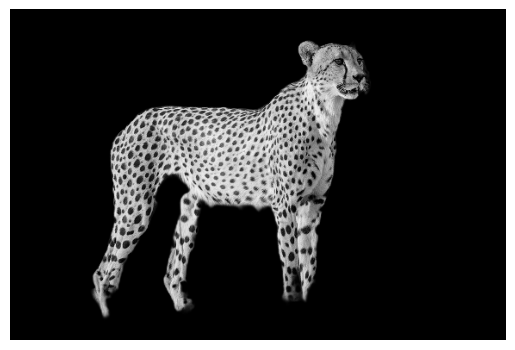

In [ ]:
rgba = remove(Image.open(IMAGE_PATH).convert("RGBA"))

gray  = np.array(ImageOps.grayscale(rgba), dtype=np.float32) / 255.0
alpha = np.array(rgba.getchannel("A"), dtype=np.float32) / 255.0
img = (gray * alpha)[..., None]

x = tf.expand_dims(img, 0)

scale = 0.6
h, w = img.shape[:2]
x = tf.image.resize(
    x,
    (int(h * scale), int(w * scale)),
    method=tf.image.ResizeMethod.BICUBIC
)

plt.imshow(tf.squeeze(x), cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.show()

In [ ]:
def show_patches(patches, n_show=12, patch_size=32, cols=4, cmap="gray"):
    # Reorganiza os patches no formato (num_patches, patch_size, patch_size, 1)
    patches = tf.reshape(patches, [-1, patch_size, patch_size, 1])
    num_patches = patches.shape[0]

    # Converte para numpy
    patches_np = patches.numpy()
    n_show = min(n_show, num_patches)

    # Define linhas e colunas
    rows = int(np.ceil(n_show / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = np.ravel(axes)

    for i, ax in enumerate(axes):
        if i < n_show:
            ax.imshow(patches_np[i, :, :, 0], cmap=cmap)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
def normalize(patches, eps=1e-8):
    normalized = []

    for p in patches:
        min_ = tf.reduce_min(p)
        max_ = tf.reduce_max(p)
        denom = tf.maximum(max_ - min_, eps)
        image = (p - min_) / denom
        normalized.append(p)

    if not normalized:
        return tf.zeros((0, *patches.shape[1:]), dtype=tf.float32)

    return tf.stack(normalized, axis=0)


In [ ]:
# separa os patches
patches = tf.image.extract_patches(
    images=x,
    sizes=[1, PATCH, PATCH, 1],
    strides=[1, STRIDE, STRIDE, 1],
    rates=[1, 1, 1, 1],
    padding="VALID",
)

# descobre quantos patches cabem
ny, nx = patches.shape[1:3]
patches = normalize(tf.reshape(patches, [-1, PATCH, PATCH, 1]))

In [ ]:
def save_invalid_patches(invalid_patches, base_path=INVALID_PATCHES_PATH):
    os.makedirs(base_path, exist_ok=True)
    count = invalid_patches.shape[0]

    for i in range(count):
        patch = tf.squeeze(invalid_patches[i], axis=-1).numpy()
        patch = np.clip(patch, 0, 1)
        filename = f"invalid_patch_{i:04d}.png"
        path = os.path.join(base_path, filename)
        plt.imsave(path, patch, cmap="gray", vmin=0, vmax=1)

In [ ]:
def select_valid_patches(
    patches, *,
    eps=0.02,
    min_nz_ratio=0.10,
    min_max=0.20,
    max_black_ratio=0.50
):
    P = tf.squeeze(patches, axis=-1)
    nz_ratio = tf.reduce_mean(tf.cast(P > eps, tf.float32), axis=(1, 2))
    mx = tf.reduce_max(P, axis=(1, 2))

    valid_mask = tf.logical_and(
        tf.logical_and(nz_ratio >= min_nz_ratio, mx >= min_max),
        (1.0 - nz_ratio) <= max_black_ratio
    )

    valid_patches = tf.boolean_mask(patches, valid_mask)
    invalid_patches = tf.boolean_mask(patches, tf.logical_not(valid_mask))

    save_invalid_patches(invalid_patches)
    return valid_patches

In [ ]:
patches_valid = select_valid_patches(patches)
# patches_valid = 1.0 - patches_valid
# só usa os válidos
pred_ratio, pred_scale = model.predict(patches_valid, batch_size=256, verbose=0)

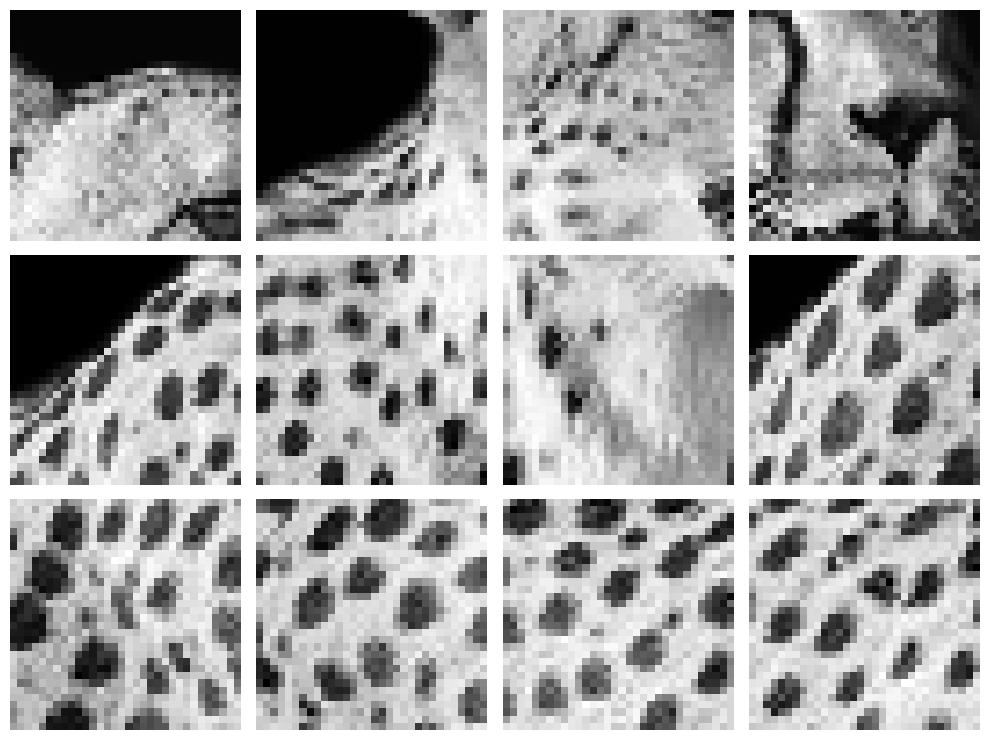

In [ ]:
show_patches(patches_valid, n_show=12, patch_size=PATCH, cols=4, cmap="gray")

In [ ]:
print(patches_valid.shape)
print(patches.shape)

(31, 32, 32, 1)
(132, 32, 32, 1)


In [ ]:
ratio_classes = np.argmax(pred_ratio, axis=1)
scale_classes = np.argmax(pred_scale, axis=1)

ratio_conf = np.max(pred_ratio, axis=1)
scale_conf = np.max(pred_scale, axis=1)

mean_conf = (ratio_conf + scale_conf) / 2

In [ ]:
results = [
    {
        "patch": i,
        "ratio_class": int(ratio_classes[i]),
        "ratio_conf": float(ratio_conf[i]),
        "scale_class": int(scale_classes[i]),
        "scale_conf": float(scale_conf[i]),
        "mean_conf": float(mean_conf[i]),
    }
    for i in range(len(ratio_classes))
]

results_conf = [r for r in results if r["mean_conf"] >= 0.9]
results_sorted = sorted(results_conf, key=lambda x: x["mean_conf"], reverse=True)

In [ ]:
print(len(patches_valid))

31


In [ ]:
def find_dataset_images(ratio_cls, scale_cls, num_samples=3):
    ratio = RATIOS[ratio_cls]
    scale = SCALES[scale_cls]
    pattern = f"gs_r{ratio:02d}_s{scale:0.2f}_n*.png"
    paths = glob(os.path.join(DATASET_PATH, pattern))
    if len(paths) > num_samples:
        paths = random.sample(paths, num_samples)
    return paths

In [ ]:
def patch2np(patch_tf):
    p = tf.squeeze(patch_tf, axis=-1).numpy()
    return np.clip(p, 0, 1)

In [ ]:
def show_patches(patches, results_sorted, K=48, cols=4):
    if not results_sorted:
        print("Nenhum resultado válido encontrado para exibição.")
        return

    indices = [r["patch"] for r in results_sorted[:K]]
    stats_by_idx = {r["patch"]: r for r in results_sorted}
    rows = max(1, math.ceil(len(indices) / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 4.0))
    axes = np.atleast_1d(axes).ravel()

    for ax, i in zip(axes, indices):
        info = stats_by_idx[i]
        patch_img = patch2np(patches[i])
        try:
            ratio_cls = info.get("ratio_class", "?")
            scale_cls = info.get("scale_class", "?")
            ratio_val = RATIOS[ratio_cls]
            scale_val = SCALES[scale_cls]
        except Exception:
            ratio_val, scale_val = "?", "?"

        ratio_conf = info.get("ratio_conf", "?")
        scale_conf = info.get("scale_conf", "?")

        ax.axis("off")
        ax.set_title(
            f"r={ratio_val}, s={scale_val:.2f}, rc={ratio_conf:.2f}, sc={scale_conf:.2f}",
            fontsize=9,
            y=0.7,
            x=0.25,
        )

        # patch central
        patch_ax = ax.inset_axes([0.05, 0.05, 0.35, 0.35])
        patch_ax.imshow(patch_img, cmap="gray", vmin=0, vmax=1)
        patch_ax.axis("off")

        # imagens geradas
        paths = find_dataset_images(ratio_cls, scale_cls)
        inset_size, x_offset, spacing, y_start = 0.20, 0.45, 0.01, 0.05

        for j, path in enumerate(paths):
            try:
                img = plt.imread(path)
            except:
                img = np.zeros((10, 10))
            inset_ax = ax.inset_axes([
                x_offset, y_start + j * (inset_size + spacing),
                0.45, inset_size
            ])
            inset_ax.imshow(img, cmap="gray", vmin=0, vmax=1)
            inset_ax.axis("off")

    for ax in axes[len(indices):]:
        ax.axis("off")

    plt.tight_layout(w_pad=0.5, h_pad=1.0)
    plt.show()


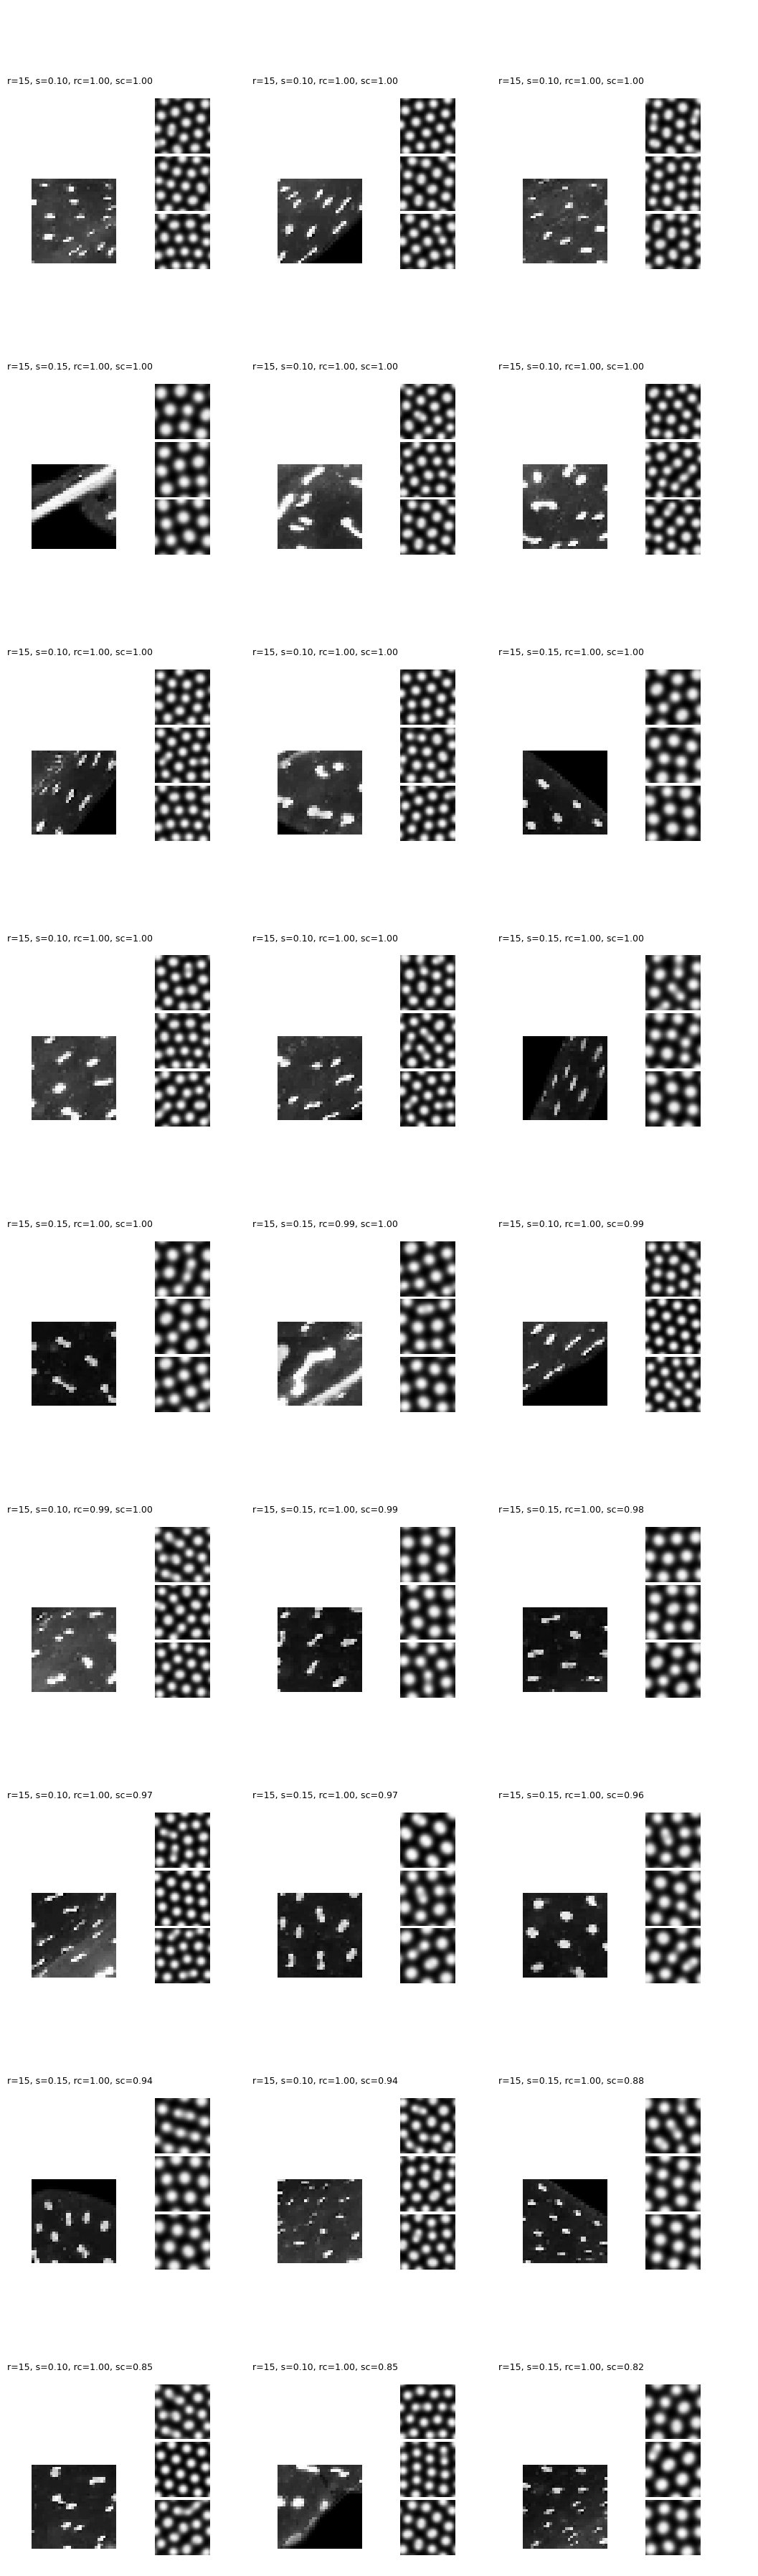

In [ ]:
# uso:
show_patches(patches_valid, results_sorted, K=30, cols=3)